# **Amazon Product Recommendation System**

In this project, we'll be diving into the Amazon electronics product reviews dataset. This dataset includes various ratings for a wide range of electronic products. To ensure an unbiased approach in our model development, it specifically omits detailed product information and individual review content.

--------------
## **Context:**
--------------

Today's world is characterized by an unprecedented growth in information, marked by significant increases in its amount, speed, and diversity. This surge has resulted in information overload, leaving consumers faced with overwhelming choices in virtually every sector. Such an abundance of options poses challenges, often leading consumers to feel paralyzed when making decisions. In this context, Recommender Systems emerge as crucial tools, offering tailored product suggestions to users as they navigate online platforms. These systems not only help in cutting down the time consumers spend searching for the right product, thereby significantly enhancing their shopping experience, but also play a pivotal role in customer retention. By providing personalized recommendations that resonate most with individual preferences, they keep users engaged and more likely to return, thereby supporting business objectives and fostering a loyal customer base.

E-commerce platforms, including Amazon, Walmart, Target, and Etsy, employ a variety of recommendation models to deliver personalized suggestions to their users. These organizations invest substantial resources in developing sophisticated algorithmic methods designed to tailor recommendations specifically for each user.

Amazon is renowned for its adept use of recommendations on its website, distinguishing itself through precise and personalized product suggestions. Its recommendation system excels in smartly deciphering and forecasting customer shopping patterns, thereby curating a tailored selection of products for each user. This sophisticated algorithm plays a pivotal role in harnessing artificial intelligence to enhance the website's personalization. A prime example of Amazon's innovative approach is its deployment of item-to-item collaborative filtering. This model is notable for its ability to handle extensive datasets and deliver top-notch recommendations instantaneously, illustrating the impactful integration of AI in refining user experience.

----------------
## **Objective:**
----------------

Suppose you are a Data Scientist for Amazon, and you've been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem.

### **Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162733 sha256=e4a44ef65b5a065988dcc6d105b23f9fe89f79b2e17e472f8b814494c51871cb
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
!pip install pygal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.4/130.4 kB 3.2 MB/s eta 0:00:00


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Libraries for mathematical operations and dataframe computations
import numpy as np
import pandas as pd

# Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pygal
from IPython.display import SVG, display
from pygal.style import LightStyle

# Subclass to prevent key error for data dictionaries missing key value pairs
from collections import defaultdict

# Library to assist with performance eval using MSE
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Elective Project/ratings_Electronics.csv', header = None, na_values=['None', 'Not Given', 'N/A', 'Unknown'])

In [ ]:
# No header at a glance so revised above code to indicate header = None
df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
df.dtypes

0     object
1     object
2    float64
3      int64
dtype: object

In [ ]:
# Rename headers based on the dataset features
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

df = df.drop('timestamp', axis = 1) # Drop timestamp column since it's not offering value as a feature

df['rating'] = df['rating'].astype(int)

df['prod_id'] = df['prod_id'].astype(str)

df_copy = df.copy(deep = True) # Back-up copy

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5
1322,A1A5KUIIIHFF4U,1400501466,1
1335,A2XIOXRRYX0KZY,1400501466,3
1451,AW3LX47IHPFRL,1400501466,5
1456,A1E3OB6QMBKRYZ,1400501466,1


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape

print("Number of rows:", rows)
print("Number of columns:", columns)

Number of rows: 65290
Number of columns: 3


**Observations**:
- There are **65,290 rows** and **3 columns** in the dataset.

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  65290 non-null  object
 1   prod_id  65290 non-null  object
 2   rating   65290 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [ ]:
# Check how many ratings categories are included in dataset
df_final['rating'].nunique()

5

**Observations**:
- The column '**rating**' is an integer because we changed this feature from a float earlier in our code. This was done because there are no decimal values of note, and ints are more memory efficient. Both '**prod_id**' and '**user_id**' were both object data types, but we adjusted prod_id to be a string since there's a mix of numbers and characters.

### **Checking for missing values**

In [ ]:
# Check for NaN values
df_final.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

In [ ]:
# Check whether ratings categories appear logical
df_final['rating'].unique()

array([5, 1, 3, 4, 2])

In [ ]:
# Check to see if there are duplicates in the dataframe
df_final.duplicated().sum()

0

**Observations**:
- There doesn't appear to be any missing values in the dataset.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observations**:
- Count appears to accurately represent the row total we saw earlier in our analysis. This helps to reassure that there are no missing values that were accidentally overlooked.
- We see that the mean value is ~4.3. The median value is a rating of 5. Since the mean is less than the median, this points towards a left-skewed distribution of ratings.

### **Checking the rating distribution**

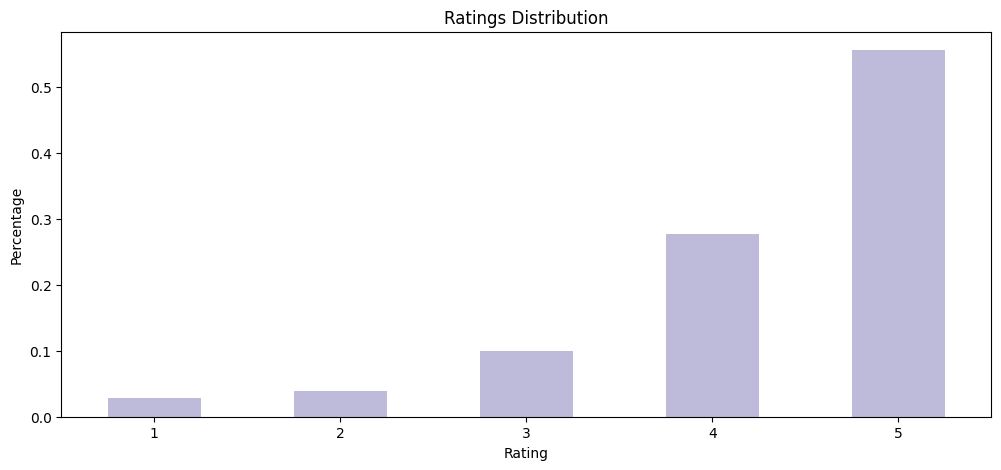

In [ ]:
plt.figure(figsize = (12, 5))
df_final['rating'].value_counts(normalize=True).sort_index().plot(kind='bar', color='#bebada')
plt.xlabel('Rating')
plt.ylabel('Percentage')
plt.title('Ratings Distribution')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Customizable count plot function
def custom_countplot(data, feature, perc=True, n=None, palette='Set3', fontsize=15, rotation=0, hue=None, title='Custom'):
    """
    Creates a customizable count plot.

    Parameters:
    data (DataFrame): The pandas DataFrame to plot.
    feature (str): DataFrame column.
    perc (bool): Whether to display percentages or counts. Defaults to True.
    palette (str): Color palette for the bars. Defaults to 'Set3'.
    rotation (int): Rotation angle for x-tick labels. Default is no rotation.
    fontsize (int): Font size for x-tick labels. Defaults to 15.
    hue (str): Optional. Column name for color encoding.
    title (str): Optional. Title for the plot. Defaults to Custom.
    """
    total = len(data[feature])
    count = data[feature]
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(fontsize=fontsize, rotation=rotation)
    plt.tick_params(labelsize=10)
    plt.title(title, fontsize=fontsize)

    ax = sns.countplot(
        data=data,
        x=feature,
        palette=palette,
        hue=feature,
        order=data[feature].value_counts().index[:n],
        legend=False
    )

    for p in ax.patches:
        if perc:
          label = '{:.1f}%'.format(100 * p.get_height() / total)
        else:
          label = '{:,}'.format(int(p.get_height()))

        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        ax.annotate(
            label,
            (x,y),
            ha='center',
            va='center',
            size=12,
            xytext=(0, 5),
            textcoords='offset points'
        )

    plt.show()

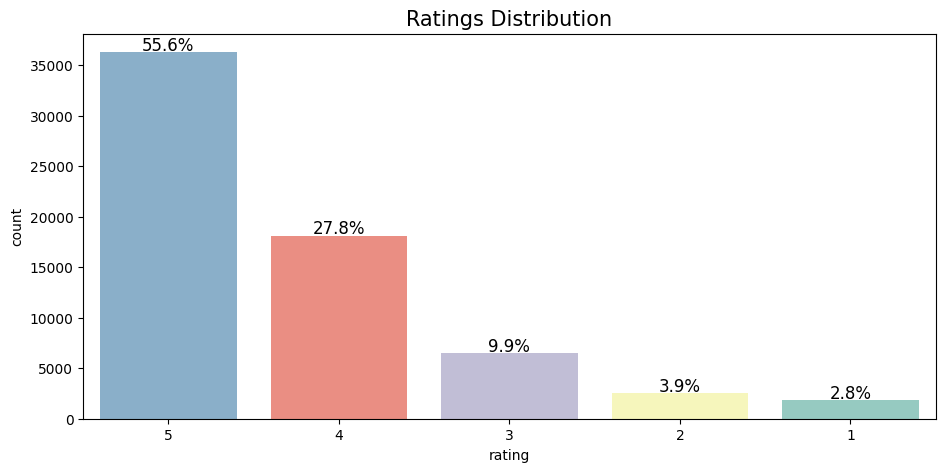

In [ ]:
# Plot including percentages associated with each rating category
custom_countplot(df_final, 'rating', perc=True, n=10, title='Ratings Distribution')

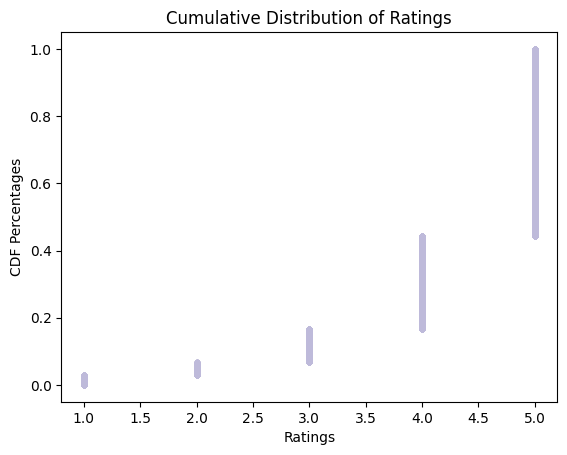

In [ ]:
total_ratings = df_final['rating']

# Calc the CDF
data_sorted = np.sort(total_ratings)
cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

# Plotting the CDF to see what percent of ratings fall under specific values
plt.plot(data_sorted, cdf, marker='.', linestyle='none', color='#bebada')
plt.xlabel('Ratings')
plt.ylabel('CDF Percentages')
plt.title('Cumulative Distribution of Ratings')

plt.show()

**Observations**:
- We see that the y axis is representing the percentage/proportion of observations with a value less than or equal to a given x-value. As an example, 60% of the data is less than or equal to 5; 40% of the data is less than or equal to 4, etc. This visualization echoes what we've seen with our other plots, showing that there is an exceedingly high amount of 5 star ratings compared against the rest of the distribution.

In [ ]:
# Isolate value counts for each rating
df_final['rating'].value_counts()

5    36315
4    18127
3     6481
2     2515
1     1852
Name: rating, dtype: int64

In [ ]:
df_final['rating'].count()

65290

**Observations**:
- The majority of ratings in the dataset are 5 stars, totaling at 36,315 ratings; almost twice as many ratings are 5 star (55.6% of ratings) vs. 4 star (27.8% of ratings), which is substantial. Ratings 1, 2, and 3 are quite low in comparison. This dataset may be biased towards 5 star ratings.
- The ratings distribution appears to be **left-skewed**.

### **Checking the number of unique users and items in the dataset**

In [ ]:
df_final['user_id'].nunique()

1540

In [ ]:
df_final['prod_id'].nunique()

5689

In [ ]:
df_final.groupby(['user_id', 'prod_id']).count()

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [ ]:
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290

**Observations**:
- There are **5689 products** in the dataset, but we only have **1540 user IDs**. Based on these metrics, there would've been the possibility of **1540 * 5689 = 8,761,060** ratings.
- We only have **65,290 ratings**, which indicates that not every individual user has rated a product.
- Since the sum of user_id and prod_id ratings equals the amount of rows in our df_final dataset, this implies there is only one interaction between the products and the user.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
top_users = df_final["user_id"].value_counts().nlargest(10).index
top_users

Index(['ADLVFFE4VBT8', 'A3OXHLG6DIBRW8', 'A1ODOGXEYECQQ8', 'A36K2N527TXXJN',
       'A25C2M3QF9G7OQ', 'A680RUE1FDO8B', 'A1UQBFCERIP7VJ', 'A22CW0ZHY3NJH8',
       'AWPODHOB4GFWL', 'AGVWTYW0ULXHT'],
      dtype='object')

In [ ]:
pd.DataFrame(top_users)

,0
0,ADLVFFE4VBT8
1,A3OXHLG6DIBRW8
2,A1ODOGXEYECQQ8
3,A36K2N527TXXJN
4,A25C2M3QF9G7OQ
5,A680RUE1FDO8B
6,A1UQBFCERIP7VJ
7,A22CW0ZHY3NJH8
8,AWPODHOB4GFWL
9,AGVWTYW0ULXHT


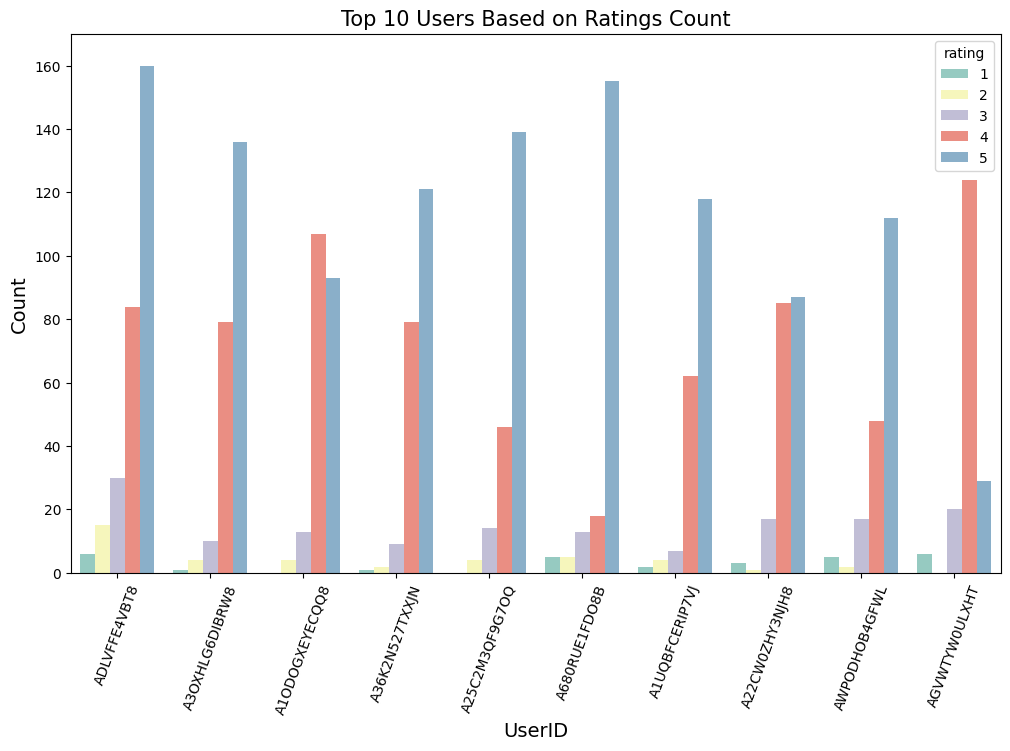

In [ ]:
# Saving new dataframe of top 10 most active users
df_top10 = df_final[df_final["user_id"].isin(top_users)]

# Visualizing top 10 users based on ratings count, including ratings 1 through 5
plt.figure(figsize=(12, 7))
plt.title("Top 10 Users Based on Ratings Count", fontsize=15)
plt.ylim(0, 170)
sns.countplot(data=df_top10, x="user_id", hue="rating", palette="Set3", order=top_users)
plt.xticks(rotation=70)
plt.xlabel('UserID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()


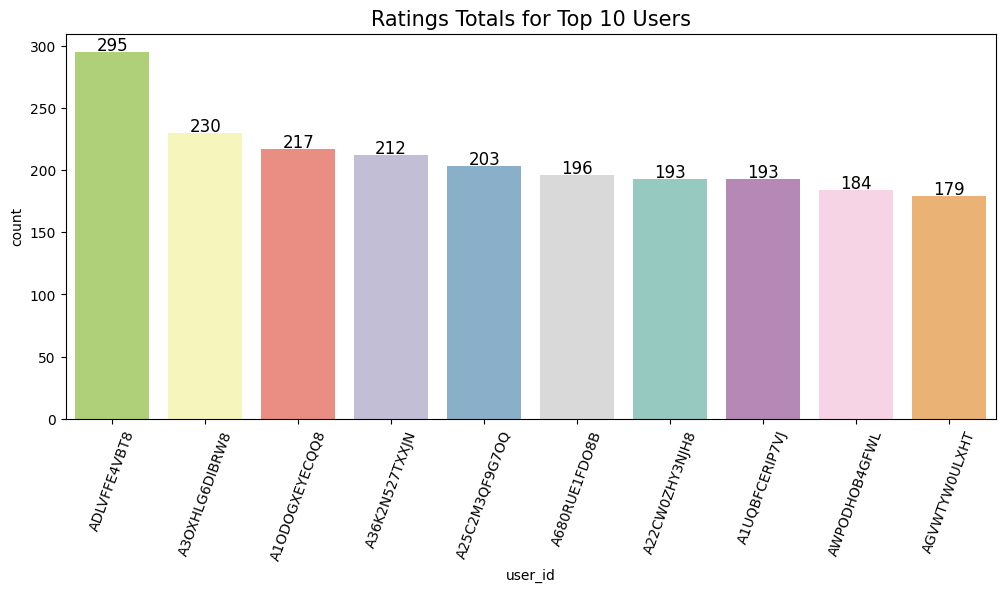

In [ ]:
# Visualize 10 most active users including total ratings
custom_countplot(df_top10, 'user_id', perc=False, n=11, palette='Set3', hue='rating', rotation=70, title="Ratings Totals for Top 10 Users")

**Observations**:
- We can see that the most active user rated **295** products. This is of note because, even as the most active user, this total is quite far off from the total products included in our dataset. This means there's an opportunity to recommend products to users that they may not have identified otherwise.

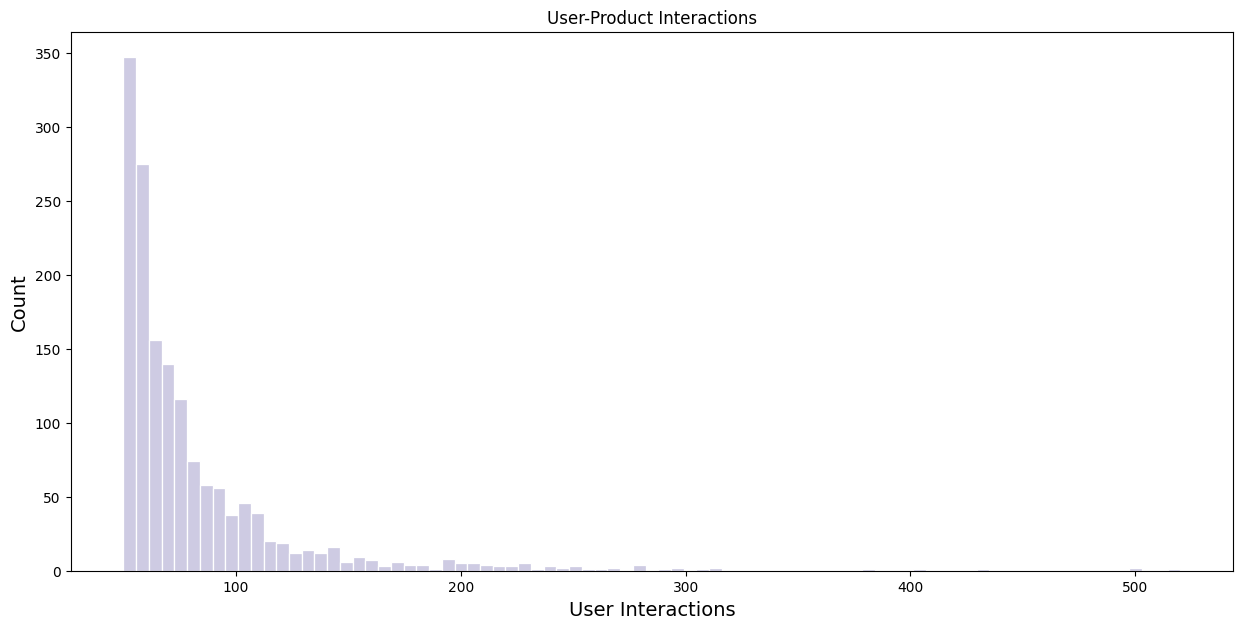

In [ ]:
# Finding user-product interactions distribution
count_interactions = df.groupby('user_id').count()['prod_id']

# Plotting user-product interaction distribution
plt.figure(figsize=(15,7))
sns.histplot(count_interactions, color='#bebada', edgecolor='white')
plt.xlabel('User Interactions', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('User-Product Interactions')
plt.show()

**Observations**:
- The distribution of user interactions with products is highly **right-skewed**. We have some very active users who may be outliers compared against the casual users who are significantly less engaged.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id').mean(numeric_only=True)['rating']
average_rating

prod_id
1400501466    3.333333
1400532655    3.833333
1400599997    4.000000
9983891212    4.875000
B00000DM9W    5.000000
                ...   
B00L21HC7A    4.625000
B00L2442H0    4.916667
B00L26YDA4    4.384615
B00L3YHF6O    5.000000
B00LGQ6HL8    5.000000
Name: rating, Length: 5689, dtype: float64

In [ ]:
# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']
count_rating

prod_id
1400501466     6
1400532655     6
1400599997     5
9983891212     8
B00000DM9W     5
              ..
B00L21HC7A    16
B00L2442H0    12
B00L26YDA4    13
B00L3YHF6O    14
B00LGQ6HL8     5
Name: rating, Length: 5689, dtype: int64

In [ ]:
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'avg_rating' : average_rating,
    'rating_count' : count_rating
})
final_rating

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5
...,...,...
B00L21HC7A,4.625000,16
B00L2442H0,4.916667,12
B00L26YDA4,4.384615,13


In [ ]:
# Sort the dataframe by average of ratings in the descending order
final_rating.avg_rating.sort_values(ascending=False).head()

prod_id
B00LGQ6HL8    5.0
B003DZJQQI    5.0
B005FDXF2C    5.0
B00I6CVPVC    5.0
B00B9KOCYA    5.0
Name: avg_rating, dtype: float64

In [ ]:
final_rating.rating_count.value_counts().head()

5    1082
6     796
7     637
8     495
9     416
Name: rating_count, dtype: int64

In [ ]:
final_rating.head()

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interactions=100):

    # Finding products with minimum number of interactions
    recommendations = data[data.rating_count > min_interactions]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending = False)
    return recommendations.index[:n]

In [ ]:
res = top_n_products(final_rating, 5, 50) # top 5 books, 50 interactions
list_of_products = []
for i in res:
  list_of_products.append(df_final[df_final['prod_id']==str(i)]['prod_id'].unique()[0])
list_of_products

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
res = top_n_products(final_rating, 5, 100) # top 5 books, 100 interactions
list_of_products = []
for i in res:
  list_of_products.append(df_final[df_final['prod_id']==str(i)]['prod_id'].unique()[0])
list_of_products

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to thea new library, called  given user.  
- We will be using `surprise` to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60.

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user.


**Recall@k** - This is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - This is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

The below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  

To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # Map predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision)

    print('Recall: ', recall)

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': True # If set to False, would show product based
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False)

# Fit the model on the training data
sim_user_user.fit(trainset)

In [ ]:
# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations**:

- **RMSE of ~1.00** is moderate. This indicates an average prediction error of 1 rating point, which can be acceptable in certain contexts. We can aim to further improve this metric.

- We can see **high precision and recall**, which is promising in terms of the model's ability to provide relevant recommendations for the users.

- The **F_1 score is fairly strong** and indicates reasonable **balance** between precision and recall.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Observations:**

**`userID=A3LDPF5FMB782Z'`
`productID=1400501466`**

- There's a moderate discrepancy in the provided rating estimation vs. the actual rating of this particular user. We can see the estimated rating is 3.40, which is not close enough to 5.00. This is not an accurate enough prediction.

- The actual_k value of **5 is a low quantity for neighbors**. We'd likely need more similar users in the calculation to improve the accuracy. This could be an issue with the amount of data used, in which case we may see other issues in the model's ability to provide predictions.

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(10, df_final, '1400501466')

['AGVWTYW0ULXHT',
 'A30KPB2ILF6K6J',
 'A36A1ZYZH8568P',
 'A15Q2L6DYRTFIU',
 'AGXMC3ITWZASE',
 'A2PK64OVZA1U8Z',
 'A2WA8TDCTGUADI',
 'A3D2VIUT2HWP0Z',
 'A2IFKH3TJ10387',
 'A250AXLRBVYKB4']

Since I'm not able to see this specific UserID from the preview of 10 users, I'm going to change the function to be more expansive by dropping n from the parameters.

In [ ]:
# Adjusting function parameters
def users_not_interacted_with(data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))

In [ ]:
# Passing specific user_id of interest through the function and saving it to new list
no_interaction_1400501466 = users_not_interacted_with(df_final, '1400501466')

In [ ]:
# Check if user 'A2UOHALGF2X77Q' has interacted with product '1400501466'
specific_user = 'A2UOHALGF2X77Q'

if specific_user in no_interaction_1400501466:
    print(f"UserID {specific_user} has NOT interacted with product 1400501466.")
else:
    print(f"UserID {specific_user} has interacted with product 1400501466.")

UserID A2UOHALGF2X77Q has NOT interacted with product 1400501466.


* It can be observed from the above that **user "A2UOHALGF2X77Q" has not seen the product with productID "1400501466"** as this user id is a part of the above list.

In [ ]:
# Get the unique product IDs that user 'A2UOHALGF2X77Q' has interacted with
interacted_products = df_final[df_final['user_id'] == 'A2UOHALGF2X77Q']['prod_id'].unique()

# Convert to DataFrame and count unique products
df_interacted_products = pd.DataFrame({'prod_id': interacted_products})
unique_product_count = df_interacted_products['prod_id'].nunique()

print("The total number of unique products user A2UOHALGF2X77Q has interacted with:", unique_product_count)

The total number of unique products user A2UOHALGF2X77Q has interacted with: 155


**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A2UOHALGF2X77Q", "1400501466", r_ui = 5, verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = 5.00   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=5, est=5.0, details={'actual_k': 1, 'was_impossible': False})

**Observations**:

**`userId=A2UOHALGF2X77Q` `prod_id=1400501466`**

- Although **A2UOHALGF2X77Q** has interacted with 155 different products, they have not interacted with **1400501466**

- Our model is estimating a perfect prediction for this particular user, but the **amount of neighbors is extremely sparse**. We can't confidently say the model is accurate with so little data in terms of similar users.



### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k' : [20, 30, 40], # neighbors including default 40
    'min_k' : [1, 3, 6], # minimum number of neighbors required including default 1
    'sim_options' : {
        'name' : ['cosine', 'msd'], # similarity measures
        'user_based' : [True] # since we're looking at user-user based similarity
        }
     }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1) # optimizing rmse, -1 to use all threads

# Fitting the data
gs.fit(data)

In [ ]:
# Best RMSE
gs.best_score['rmse']

0.9721589613107368

In [ ]:
# Combination of parameters that gave the best RMSE score
gs.best_params['rmse']

{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}

Once the grid search is **complete**, we can see the **optimal values for each of those hyperparameters**.


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {
    'name' : 'cosine',
    'user_based' : True
}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_user_user_optimized = KNNBasic(40, 6, sim_options=sim_options)

# Training the algorithm on the trainset
similarity_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(similarity_user_user_optimized)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


### **User-User Similarity-based Collaborative Filtering Recommendation System**

**Baseline Model Metrics**:

- RMSE: 1.0012

- Precision:  0.855

- Recall:  0.858

- F_1 score:  0.856

**Post-Tuning Model Metrics**:

- RMSE: 0.9526

- Precision:  0.847

- Recall:  0.894

- F_1 score:  0.87


**Observations**:

- **RMSE** has impoved post-tuning, indicating slightly better prediction capability.

- **Precision** is showing a minor decrease, but we see a notable uptick in **Recall**, suggesting that the model is now capturing more relevant items at the expense of very slightly more false positives.

- **F_1 Score** is showing overall balance between precision and recall.

These changes do show that hyperparameter tuning improved overall performance of the model, especially in terms of its ability to capture relevant items (recall) and overall prediction accuracy (RMSE). We do see a slight decrease in precision, but it's very minor and we see important improvements across the other metrics in this case.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466")

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
similarity_user_user_optimized.predict("A2UOHALGF2X77Q", "1400501466")

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Let's look at a couple more users to see if the 'Not enough neighbors' issue persists.**

In [ ]:
# Check userID that we know has interacted with products
similarity_user_user_optimized.predict("A9Y5O2R4D6EH5", "1400501466")

Prediction(uid='A9Y5O2R4D6EH5', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Check additional userID that we know has interacted with products
similarity_user_user_optimized.predict("AX7317G153T8W", "1400501466")

Prediction(uid='AX7317G153T8W', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**:

- For all of the above attempts, we are seeing a continuous issue of "**Not enough neighbors**." This appears to be a **data sparsity issue**, and it limits our model's ability to make good predictions since there aren't enough similar users.

- Seeing that **'was_impossible' is True**, this estimation is based on the global mean or baseline est, which is why all four examples have the same est value.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
similarity_user_user_optimized.get_neighbors(0,k=5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating') # creates pivot table

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, similarity_user_user_optimized)
recommendations

[('B000067RT6', 5.0),
 ('B000BQ7GW8', 5.0),
 ('B001TH7GUU', 5.0),
 ('B005ES0YYA', 5.0),
 ('B00834SJSK', 5.0)]

In [ ]:
# Checking output if we increase the list of item predictions to be more expansive
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 15, similarity_user_user_optimized)
recommendations

[('B000067RT6', 5.0),
 ('B000BQ7GW8', 5.0),
 ('B001TH7GUU', 5.0),
 ('B005ES0YYA', 5.0),
 ('B00834SJSK', 5.0),
 ('B00E3W15P0', 5.0),
 ('B00006RVPW', 4.999999999999999),
 ('B004RORMF6', 4.999999999999999),
 ('B002WE6D44', 4.937476099202093),
 ('B000N99BBC', 4.874904360234503),
 ('B003ES5ZUU', 4.866666666666666),
 ('B001XURP7W', 4.857142857142857),
 ('B0041Q38NU', 4.857142857142857),
 ('B00483WRZ6', 4.857142857142857),
 ('B004CLYEFK', 4.857142857142857)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(
    recommendations,
    columns = ['prod_id', 'predicted_ratings']
)

,prod_id,predicted_ratings
0,B000067RT6,5.000000
1,B000BQ7GW8,5.000000
2,B001TH7GUU,5.000000
3,B005ES0YYA,5.000000
4,B00834SJSK,5.000000
5,B00E3W15P0,5.000000
6,B00006RVPW,5.000000
7,B004RORMF6,5.000000
8,B002WE6D44,4.937476
9,B000N99BBC,4.874904


Although the above is helpful in predicting products that the user may favor, it's possible that some of these items have more ratings than others, so we may not be seeing the 'best' list of recommendations. For example, if item at index 0 only has 5 ratings and item at index 1 has 50, there's more strength in predicting the item at index 1.

In [ ]:
 # Define function to provide adjusted ratings based on the amt of ratings each specific item received
 def ranking_prods(recommendations, final_rating):

   # Index into the final ratings df and select products that are recommended, sorting ratings descending
   ranked_prods = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

   # Merge recommended products to get predicted ratings
   ranked_prods = ranked_prods.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

   # Rank the products using the adjusted ratings
   ranked_prods['adjusted_ratings'] = ranked_prods['predicted_ratings'] - 1/np.sqrt(ranked_prods['rating_count']) # - 1/np.sqrt because we don't want above rating 5

   # Sort the products based on the adjusted ratings
   ranked_prods = ranked_prods.sort_values('adjusted_ratings', ascending=False)

   return ranked_prods

In [ ]:
ranking_prods(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,adjusted_ratings
2,B00834SJSK,101,5.000000,4.900496
6,B001TH7GUU,78,5.000000,4.886772
8,B000BQ7GW8,54,5.000000,4.863917
9,B00E3W15P0,48,5.000000,4.855662
10,B000067RT6,41,5.000000,4.843826
3,B002WE6D44,100,4.937476,4.837476
12,B004RORMF6,34,5.000000,4.828501
13,B00006RVPW,31,5.000000,4.820395
14,B005ES0YYA,26,5.000000,4.803884
1,B000N99BBC,167,4.874904,4.797522


**Observations**:

- The initial predictions didn't take into account the amount of ratings each product had received respectively, and it's important to incorporate those metrics into our analysis. This is why we implemented the **ranked_prods** function to gather this information as a column in the above recommendations, specifically using '**adjusted_ratings**'.

- Although we see the model is functioning as intended, we also need to **remember the 'not enough neighbors' issue** we encountered while attempting to optimize the hyperparameters earlier in this exercise. The model is promising, but that doesn't mean it's going to be fully accurate in its predictions.

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': False # If set to True, would show user_based like what we performed earlier
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_item_item = KNNBasic(sim_options=sim_options)

# Fit the model on the training data
sim_item_item.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
# Let's compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Observations**:

- RMSE could be better; this is a fairly high amount of average errors in predicted ratings. Let’s aim to improve this during fine-tuning.
- A precision of 0.838 suggests that approximately 83.8% of the items recommended by the model are relevant or 'true positives.' This is a strong and desirable score.
- Similarly, recall is looking strong at 0.845, identifying 84.5% of the relevant items for the users.
- F_1 score is echoing what we see with precision and recall; we have good balance here.


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466")

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

In [ ]:
# Get the unique product IDs that user 'A3LDPF5FMB782Z' has interacted with
int_prod_A3LDPF5FMB782Z = df_final[df_final['user_id'] == 'A3LDPF5FMB782Z']['prod_id'].unique()

# Convert to DataFrame and count unique products
df_int_prod_A3LDPF5FMB782Z = pd.DataFrame({'prod_id': int_prod_A3LDPF5FMB782Z})
uni_prod_count_A3LDPF5FMB782Z = df_int_prod_A3LDPF5FMB782Z['prod_id'].nunique()

print("The total number of unique products user A3LDPF5FMB782Z has interacted with:", uni_prod_count_A3LDPF5FMB782Z)

The total number of unique products user A3LDPF5FMB782Z has interacted with: 31



**Observations**:

`userID=A3LDPF5FMB782Z` `productID=1400501466`

- In contrast to our user-user based approach, we see a **healthy number of neighbors for this item**, as indicated the **actual_k of 22** similar items. We also see a fairly specific est of 4.27, as opposed to a rounded whole number prediction like what we saw with the user-user similarity based approach.

- We see that was_impossible is False, meaning this prediction was doable using standard collaborative filtering mechanisms.



Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A2UOHALGF2X77Q", "1400501466")

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

In [ ]:
user_A2UOHALGF2X77Q_intprods = pd.DataFrame(interacted_products)
user_A2UOHALGF2X77Q_intprods

,0
0,B000068O34
1,B00006IS4X
2,B00008Y0VN
3,B0001FTVE0
4,B00065X51U
...,...
150,B00IQ0SDVY
151,B00IVPU786
152,B00IYU7XTE
153,B00JC5Y6WM


**Observations**:

`userID=A2UOHALGF2X77Q` `productID=1400501466`

- Note that userID `A2UOHALGF2X77Q` has interacted with 155 products, as shown by the dataframe above. This is relevant because our prediction shows **1 neighbor**, and it can't be due to lack of interaction with items in general.  It's possible that this user behavior includes high interaction with a specific *type* of item that is not related to `1400501466`. This complicates the model's ability to find multiple similar items.

- It's possible that the algorithm’s sensitivity or threshold for determining similarity between the items is too strict, meaning only *very* closely related items are considered neighbors.


### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k' : [10, 20, 30],
    'min_k' : [3, 6, 9],

    'sim_options' : {
        'name' : ['msd', 'cosine'],
        'user_based' : [False]
    }
}
# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
grid_obj.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [ ]:
# Best RMSE score
print(grid_obj.best_score)

{'rmse': 0.9758803767731107}


In [ ]:
# Find the combination of parameters that gave the best RMSE score
print(grid_obj.best_params)

{'rmse': {'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_item_item_optimized = KNNBasic(sim_options={
    'name' : 'msd', 'user_based' : False
},
k=30,
min_k=9
)

# Training the algorithm on the trainset
similarity_item_item_optimized.fit(trainset)

# Let's compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(similarity_item_item_optimized)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9567
Precision:  0.838
Recall:  0.889
F_1 score:  0.863


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

**Baseline Model Metrics**:
- RMSE: 0.9950
- Precision:  0.838
- Recall:  0.845
- F_1 score:  0.841

**Post-Tuning Model Metrics**:
- RMSE: 0.9567
- Precision:  0.838
- Recall:  0.889
- F_1 score:  0.863

**Observations**:

- There's a significant **improvement in recall**, which helps to explain the **improved F_1 score** as well. The model does not lose precision despite the increase in recall.

- **RMSE has decreased**, meaning that the model's predictions have become more accurate on average.

- We see that **precision has not changed**, which suggests that the model's ability to output relevant recommendations has remained consistent. This is good considering the improvement in recall.

- The performance metrics post-tuning are showing nice improvements, with more relevant recommendations and fewer misses.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

**Observations**:

`userID=A3LDPF5FMB782Z` `productID=1400501466`

- This prediction appears to be a strong and positive recommendation, suggesting that the user 'A3LDPF5FMB782Z' is likely to be interested in item '1400501466'.

- We can also see that the high estimated
rating combined with a substantial actual_k value shows a well-functioning model that can make confident predictions.

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
similarity_item_item_optimized.predict('A2UOHALGF2X77Q', '1400501466')

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**:

`userID=A2UOHALGF2X77Q` `productID=1400501466`

- Unfortunately, the model is showing there are **not enough neighbors** to perform the prediction for this user/item pairing. Although it's predicting ~4.29, that might not very reliable, and there seems to be a data sparsity problem.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
similarity_item_item_optimized.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, similarity_item_item_optimized)
recommendations

[('1400532655', 4.292024046561495),
 ('1400599997', 4.292024046561495),
 ('9983891212', 4.292024046561495),
 ('B00000DM9W', 4.292024046561495),
 ('B00000J1V5', 4.292024046561495)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


In [ ]:
ranking_prods(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,adjusted_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


**Observations**:

- We adjusted ratings based on the number of ratings each product has actually received.

- Low number of ratings per product means we need to be cautious in trusting these recommendations; it's another indication that there's a **data sparsity theme**.

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8887
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Observations**:

- The **RMSE is lower than our previous models**, which is indicative of improved accuracy in the model's predictions. We have a fairly limited range of ratings, so seeing an RMSE that is this low is a good sign. It suggests that, on average, the model's predictions are less than one point away from the actual rating.


- This is a **good precision score**, and it means about 85.3% of the items recommended by the model are ***relevant*** to the users. Precision can be especially important in situations where irrelevant recommendations could potentially dissatisfy customers/users.

- Recall for this model is strong. The model is capable of identifying 88% of all relevant items. This indicates that the model is **effective at not missing items** that should be recommended to the user.

- The F_1 score is showing good balance between precision and recall from this model.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Observations**:

- The SVD model's prediction is slightly lower than the actual rating. We also see that This difference between predicted and actual values can also potentially be due to the inherent unpredictability of individual user preference.


**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A2UOHALGF2X77Q", "1400501466", verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.16   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.156510633154892, details={'was_impossible': False})

**Observations**:

- We can see a highly specific estimation which is a testament to the model's ability to be **nuanced in its predictions**, clearly picking up on subtle preferences and characteristics of this user. This is promising.

- This user has not interacted with this product previously, as shown by `r_ui = None`, so we don't have a rating to evaluate our prediction against.

- We see was_impossible is False, meaning we didn't have to rely on the model's fallback mechanisms (like what we saw with some of the previous models that used the global mean where was_impossible was True).

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {
    'n_epochs' : [10, 20, 30],
    'lr_all' : [0.001, 0.005, 0.01],
    'reg_all' : [0.2, 0.4, 0.6]

}
# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

In [ ]:
# Best RMSE score
print(gs_.best_score['rmse'])

0.8994536668442462


In [ ]:
# Combination of parameters that gave the best RMSE score
print(gs_.best_params)

{'rmse': {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8822
Precision:  0.854
Recall:  0.884
F_1 score:  0.869


**Observations**:

- The baseline SVD model is performing pretty well in terms of both accuracy as per low RMSE, and also relevance (high precision and recall).

- We see a good balance between precision and recall based on the F_1 score.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z','1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.0394144191097014, details={'was_impossible': False})

In [ ]:
# Use svd_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
svd_optimized.predict('A2UOHALGF2X77Q','1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.08   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.081420748097214, details={'was_impossible': False})


### **Model-Based Collaborative Filtering - Matrix Factorization using SVD**

**Baseline Model Metrics**:

- RMSE: 0.8887
- Precision: 0.853
- Recall: 0.88
- F_1 score: 0.866

**Post-Tuning Model Metrics**:

- RMSE: 0.8810
- Precision: 0.854
- Recall: 0.878
- F_1 score: 0.866

**Observations**:

- Since we're using SVD, even a minor improvement in RMSE is still worth noting; small reduction is still a good indicator of the model's ability to make more accurate predictions.

- The slight changes in precision and recall suggest minor trade-offs occurring between correctly identifying relevant items and potentially avoiding irrelevant ones. These changes are fairly minor in terms of changes to the model's performance

- F1 score is stable and unchanged, and we still have a healthy balance between precision and recall.

In [ ]:
# Set the parameter space to tune
param_grid = {
    'n_epochs' : [10, 20, 30],
    'lr_all' : [0.001, 0.005, 0.01],
    'reg_all' : [0.2, 0.4, 0.6]

}
# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

In [ ]:
# Best RMSE score
print(gs_.best_score['rmse'])

0.8992408711130363


In [ ]:
# Combination of parameters that gave the best RMSE score
print(gs_.best_params)

{'rmse': {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}}


In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8810
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


### **Conclusion and Recommendations**

We've successfully trained and tested three models to see which model performs the best in terms of accurate predictions of relevant items for specific users. We also explored a rank-based approach, which does not learn from user-item interactions in the same way as the other models mentioned. Although rank-based is helpful as a straightforward baseline to compare against more sophisticated models, let's focus on the below to achieve the best model performance in terms of recommendations. We'll review the performance associated with each model, and then consider ways to further improve this performance and provide business recommendations.

#### **User-User Similarity-based Collaborative Filtering Recommendation System**

- The model did show improvement post-tuning, particularly in recall and RMSE, indicating better overall prediction capability as well as coverage of the relevant items. There is a slight trade-off in precision here.

 ***How can we improve?***
- Addressing the '**not enough neighbors**' issue might enhance the model's reliability. This is ultimately a **data sparsity issue** as mentioned in earlier observations.

#### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

- We see a significant **improvement in recall and a decrease in RMSE** post-tuning. Precision remained consistent despite the increase in recall, indicating a fairly well-balanced model.

 ***How can we improve?***
- **Fine-tuning the algorithm's sensitivity & threshold** for determining item similarity could potentially find more neighbors and subsequently improve the predictions. This would be a helpful additional exercise to see if we can get these performance metrics even better.

#### **Model-Based Collaborative Filtering - Matrix Factorization using SVD**

- We see minor **improvements in precision and RMSE, a slight decrease in recall, and a stable F1 score**. Overall, this indicates a balanced model with some slight enhancements in prediction accuracy. The difference between the baseline model and the fine-tuned model is not drastic, and we saw more substantial enhancements when we fine-tuned the user-user and item-item similarity-based collaborative filtering models.  That said...this is still performing the best.

 ***How can we improve?***
- We could definitely try additional hyperparameter tuning to see if we can get better results, though the current changes are already positive.

Of the above models, the **SVD model** looks best for overall balance and performance, **particularly in terms of RMSE**, which is really important for rating predictions. There are admittedly issues with ALL models due to **data sparsity**. Addressing this problem (perhaps by finding ways to utilize more user-item interactions) could enhance model performance. Lastly, the **dataset is skewed towards higher ratings, which could be affecting model performance**. Techniques like **normalization** or **stratified sampling** might help address the bias we encountered in our analysis.

#### **Business Recommendations**

- We had a handful of predictions where there weren't enough neighbors to make confident predictions, even though the user was actively engaging with other items. This is a data sparsity issue, but it also might be due to interaction with an over-concentration of specific items. This could also point towards the reasoning behind some of the **high-rating bias** we see in the dataset. The solution would be to ensure there is a diverse range of products; we want to avoid unevenly high concentration of certain item types.

- Amazon should consider implementation of mechanisms that could better **capture real-time user feedback** on recommendations, as this could further refine the model performance. Amazon should also try to **incentivize users to add ratings**, perhaps with coupons/discounts/rewards of some kind. Another viable option might be automatic emails a few weeks after the user's initial purchase to check-in on how they're enjoying the product.

- It'd be helpful to **engage less active users** by recommending items similar to those rated by similar users, as this would likely lead to better user interaction and sales.

- Besides formal ratings from users, Amazon could **track user interactions** such as clicks, views, cart additions, saved-for-later products, etc. These would be useful indicators of user preferences.

- Utilize **additional product categories** besides just electronics. It might also be helpful to extend the time range of the data collection to see if this helps collect additonal useful data.

- Try incorporating **content-based features** such as product descriptions, category info, and manufacturer details. Further insights could be obtained using NLP to analyze preferences.




